# Neural Networks and Deep Learning (ECS659P/ECS7026P)

Aashika Elavarasan

230356836

**Setup and Configuration**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR

**Data Loading and Preprocessing**

In [ ]:
from torchvision import transforms

# Define transformations for the training dataset
# These transformations include random cropping, horizontal flipping, rotation, and color jittering
# to augment the data and help the model generalize better from the training data.
# Finally, the images are converted to tensors and normalized.
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crops the image with padding of 4 on each side
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Transformations for the test dataset are simpler as we don't want to augment the testing data.
# Here we only convert the images to tensors and normalize them.
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the CIFAR-10 training dataset, applying the defined transformations
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)  # DataLoader for training data

# Load the CIFAR-10 testing dataset, applying the defined transformations
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)  # DataLoader for testing data

# Check for GPU availability and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



100%|██████████| 170498071/170498071 [00:13<00:00, 13023939.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Model Architecture**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs, dropout_rate=0.5):
        super(IntermediateBlock, self).__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout_rate))
        self.layers = nn.Sequential(*layers)
        self.fc = nn.Linear(in_channels, num_convs)

    def forward(self, x):
        # Calculate the average across spatial dimensions for each channel
        avg_pool = F.adaptive_avg_pool2d(x, (1, 1))
        avg_pool = avg_pool.view(avg_pool.size(0), -1)

        # Use a fully connected layer to compute weights for each convolution
        a = F.softmax(self.fc(avg_pool), dim=1)

        # Apply each convolution to the input and stack the results
        conv_outputs = torch.stack([conv(x) for conv in self.convs], dim=1)

        # Combine the convolution outputs according to the weights in 'a'
        out = torch.einsum('bn,bnchw->bchw', a, conv_outputs)

        return out



In [ ]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
class SimplifiedCIFAR10Net(nn.Module):
    def __init__(self):
        super(SimplifiedCIFAR10Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Linear(64 * 8 * 8, 600)
        # self.drop = nn.Dropout2d(0.25)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(600, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



**Training Setup and Evaluation**

In [ ]:
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR



model = SimpleConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=30)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Initialize lists to store metrics
epoch_losses = []
train_accuracies = []
test_accuracies = []

# Define the calculate_accuracy function outside the loop to avoid redefinition
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

for epoch in range(50):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    # Calculate and store metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)

    train_accuracy = calculate_accuracy(model, train_loader)
    test_accuracy = calculate_accuracy(model, test_loader)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Loss: 1.7170, Train Acc: 46.61%, Test Acc: 51.89%
Epoch 2, Loss: 1.4136, Train Acc: 54.37%, Test Acc: 58.16%
Epoch 3, Loss: 1.2619, Train Acc: 59.59%, Test Acc: 62.95%
Epoch 4, Loss: 1.1679, Train Acc: 61.72%, Test Acc: 65.31%
Epoch 5, Loss: 1.0985, Train Acc: 65.11%, Test Acc: 68.79%
Epoch 6, Loss: 1.0391, Train Acc: 66.32%, Test Acc: 69.79%
Epoch 7, Loss: 0.9921, Train Acc: 68.01%, Test Acc: 71.62%
Epoch 8, Loss: 0.9589, Train Acc: 69.49%, Test Acc: 72.75%
Epoch 9, Loss: 0.9297, Train Acc: 69.87%, Test Acc: 73.19%
Epoch 10, Loss: 0.9015, Train Acc: 69.53%, Test Acc: 72.19%
Epoch 11, Loss: 0.8843, Train Acc: 71.55%, Test Acc: 74.76%
Epoch 12, Loss: 0.8565, Train Acc: 72.76%, Test Acc: 75.95%
Epoch 13, Loss: 0.8435, Train Acc: 72.37%, Test Acc: 75.38%
Epoch 14, Loss: 0.8335, Train Acc: 74.20%, Test Acc: 77.00%
Epoch 15, Loss: 0.8073, Train Acc: 73.16%, Test Acc: 76.42%
Epoch 16, Loss: 0.7962, Train Acc: 75.08%, Test Acc: 77.39%
Epoch 17, Loss: 0.7798, Train Acc: 74.62%, Test A

**Visualization**

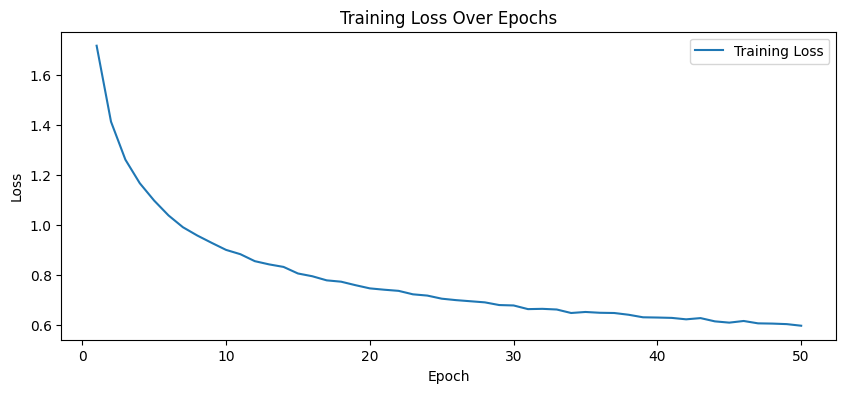

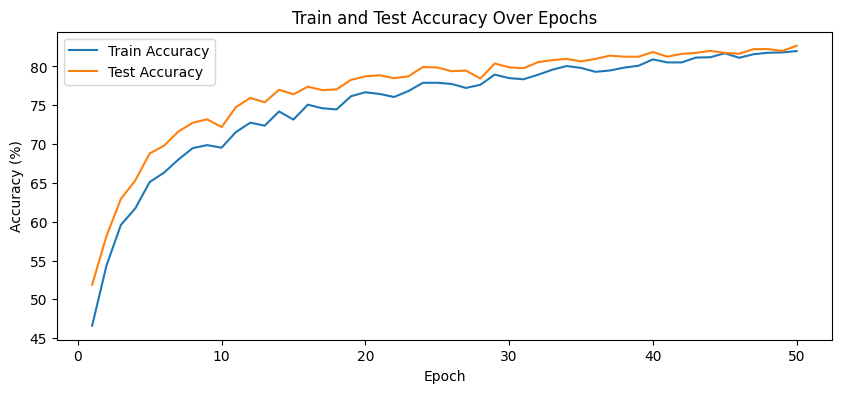

In [ ]:
# After training, plot the metrics
import matplotlib.pyplot as plt
import numpy as np

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, 51), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, 51), train_accuracies, label='Train Accuracy')
plt.plot(np.arange(1, 51), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy Over Epochs')
plt.legend()
plt.show()